In [1]:
from volumeSpikeDetector import *
from utility import *
# volume spike detector
import pandas as pd
import numpy as np
from datetime import date
from nsepy import symbols
from indicators import *
import yfinance as yf
import sys
from IPython.display import display, clear_output
from IPython.utils import io
import time
from bbRsiFitler import bbRsiFiler



In [2]:
symbols= list(pd.read_csv("strat1_symbols.csv").symbol)
len(symbols)

58

In [3]:
with io.capture_output() as captured:
    loaded_data=load_data(symbols)
    isDataLoaded=True
result = bbRsiFiler(loaded_data)

In [5]:
open_trades = result[result['Entry_date'] > "2023-08-20"]
open_trades

,Symbol,Date,Entry_date,Entry_price,Exit_date,Exit_price,Profit
27,AEGISCHEM,2023-08-21,2023-08-21,349.950012,2023-08-21,349.950012,0.0
93,BAJAJHLDNG,2023-08-21,2023-08-21,7001.799805,2023-08-21,7001.799805,0.0
224,DABUR,2023-08-28,2023-08-28,554.150024,2023-08-28,554.150024,0.0
225,DABUR,2023-08-29,2023-08-29,550.150024,2023-08-29,550.150024,0.0
392,GRASIM,2023-08-24,2023-08-24,1778.050049,2023-08-24,1778.050049,0.0
719,RAJESHEXPO,2023-08-29,2023-08-29,487.350006,2023-08-29,487.350006,0.0


## Momentum-Mean Reversion Based strategy
I'm glad to hear that the strategy is performing well! Let me explain the strategy in detail:

**Strategy Name:** Mean Reversion and Momentum Strategy with Trailing Stop Loss

**Objective:** The strategy aims to capitalize on both mean reversion and momentum opportunities in the market. It identifies potential mean reversion points using Bollinger Bands and RSI, and it identifies momentum opportunities using a short-term SMA. The strategy also incorporates a trailing stop loss to protect profits while allowing for further upside.

**Indicators Used:**
1. **Bollinger Bands (BBands):** Bollinger Bands consist of three lines: the middle line (SMA), an upper band (SMA + deviation), and a lower band (SMA - deviation). The Bollinger Bands help identify potential price reversal points when the price moves beyond the bands.

2. **Relative Strength Index (RSI):** RSI is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and identifies overbought (above 70) and oversold (below 30) conditions.

3. **Simple Moving Average (SMA):** A short-term SMA is used to determine momentum trends. If the price crosses above the SMA, it indicates positive momentum.

**Strategy Execution:**
1. **Buy Signal:** The strategy initiates a buy signal when all the following conditions are met:
   - The closing price is below the lower Bollinger Band, indicating a potential mean reversion opportunity.
   - The RSI is below the oversold threshold (RSI < 30), suggesting that the asset is oversold.
   - No open positions (not already in a trade).
   
   When these conditions are satisfied, the strategy executes a buy order and records the buy price and datetime.

2. **Trailing Stop Loss:** After a buy order is executed, the strategy calculates a trailing stop loss price, which is a certain percentage below the buy price. This trailing stop price is designed to protect profits as the price moves in favor of the position. The trailing stop never decreases; it only adjusts upwards to capture potential profits.

3. **Sell Signal:** The strategy initiates a sell signal when one of the following conditions is met:
   - The current closing price is below the trailing stop loss price, indicating a possible downtrend or a trailing stop hit.
   - The current closing price is above the short-term SMA, suggesting that positive momentum is present.

   When any of these conditions are satisfied, the strategy executes a sell order, and the position is closed. If the sell order results in a profit (closing price higher than the buy price), the trade is counted as a winning trade.

**Win Rate Calculation:** The win rate is calculated by dividing the number of winning trades by the total number of completed trades. A trade is considered completed when both the buy and sell orders are executed.

**Summary:** The strategy combines mean reversion and momentum indicators to identify potential entry and exit points. It looks for mean reversion opportunities when the price deviates from the Bollinger Bands and is oversold based on the RSI. It also considers positive momentum when the price crosses above the short-term SMA. The use of a trailing stop loss helps protect profits while allowing for further gains.

Keep in mind that past performance does not guarantee future results, and thorough backtesting and validation are essential before using any strategy in real trading. If you have any more questions or need further clarification, feel free to ask!

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-01-29 - Price: 13634.60
Selling at 2021-02-01 - Price: 14281.20
Buying at 2022-02-24 - Price: 16247.95
Selling at 2022-03-04 - Price: 16245.35
Buying at 2022-05-12 - Price: 15808.00
Selling at 2022-05-17 - Price: 16259.30
Buying at 2022-06-16 - Price: 15360.60
Selling at 2022-06-24 - Price: 15699.25
Buying at 2022-09-28 - Price: 16858.60
Selling at 2022-10-04 - Price: 17274.30
Buying at 2022-12-23 - Price: 17806.80
Selling at 2022-12-29 - Price: 18191.00
Buying at 2023-02-27 - Price: 17392.70
Selling at 2023-03-03 - Price: 17594.35
Ending Portfolio Value: 101951.31
winning trades : 6 total trades: 7
Win Rate: 85.71%


<IPython.core.display.Javascript object>


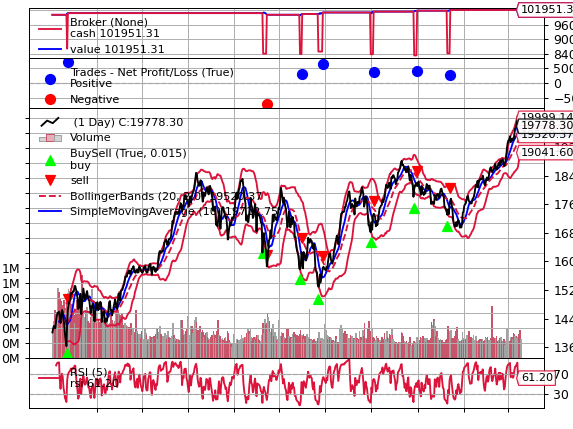

Ending Portfolio Value: 101951.31


In [29]:
import backtrader as bt
import yfinance as yf
import plotly.graph_objects as go

class MyStrategy(bt.Strategy):
    params = (
        ('bbands_period', 20),
        ('bbands_devfactor', 2.0),
        ('rsi_period', 5),
        ('rsi_oversold', 15),
        ('sma_period', 10),
        ('trailing_stop_percent', 0.03),
    )
    isPosition = False
    total_trades = 0
    winning_trades = 0
    buy_datetime = None
    buy_price = 0
    trailing_stop = None

    def __init__(self):
        self.bbands = bt.indicators.BollingerBands(self.data.close, period=self.params.bbands_period, devfactor=self.params.bbands_devfactor)
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)

    def next(self):
        if not self.position and self.data.close[0] < self.bbands.lines.bot[0] and self.rsi[0] < self.params.rsi_oversold:
            self.buy_datetime = self.data.datetime.datetime(0)
            self.buy_price = self.data.close[0]
            self.buy()
            self.total_trades += 1
            print(f"Buying at {self.buy_datetime.date().isoformat()} - Price: {self.buy_price:.2f}")
            self.trailing_stop = self.buy_price * (1.0 - self.params.trailing_stop_percent)
            self.isPosition = True

        if self.isPosition:
            if self.data.close[0] * (1.0 - self.params.trailing_stop_percent) > self.trailing_stop:
                self.trailing_stop = self.data.close[0] * (1.0 - self.params.trailing_stop_percent)

            if self.data.close[0] < self.trailing_stop or self.data.close[0] > self.sma_short[0]:
                self.sell()
                #self.total_trades += 1
                print(f"Selling at {self.data.datetime.datetime(0).date().isoformat()} - Price: {self.data.close[0]:.2f}")
                self.isPosition = False
                if self.data.close[0] > self.buy_price:
                    self.winning_trades += 1

    def stop(self):
        print(f"Ending Portfolio Value: {self.broker.getvalue():.2f}")
        if self.total_trades > 0:
            win_rate = (self.winning_trades / self.total_trades) * 100
            print(f"winning trades : {self.winning_trades} total trades: {self.total_trades}")
            print(f"Win Rate: {win_rate:.2f}%")

if __name__ == '__main__':
    cerebro = bt.Cerebro()

    # Add your desired cash amount here (defaulting to 10000)
    start_cash = 100000
    cerebro.broker.set_cash(start_cash)

    # Add the data feed
    data = yf.download('^NSEI', start='2021-01-01', end='2023-07-27')
    data = bt.feeds.PandasData(dataname=data)

    cerebro.adddata(data)
    cerebro.addstrategy(MyStrategy)

    # Set the commission to simulate realistic trading costs
    cerebro.broker.setcommission(commission=0.001)

    print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

    # Add analyzers to plot entry and exit points
    cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

    # Run the strategy
    results = cerebro.run()
    cerebro.plot()

    # Print the final portfolio value
    print(f'Ending Portfolio Value: {cerebro.broker.getvalue():.2f}')

    # Plot the price graph with entry and exit points using plotly
    #fig = cerebro.plot(style='candle', volume=False, width=1000, height=500, iplot=False, use_plotly=True)
    #fig.show()

In [29]:
import backtrader as bt
import yfinance as yf
import plotly.graph_objects as go
import pandas as pd
class MyStrategy(bt.Strategy):
    params = (
        ('bbands_period', 20),
        ('bbands_devfactor', 2.0),
        ('rsi_period', 5),
        ('rsi_oversold', 15),
        ('sma_period', 10),
        ('trailing_stop_percent', 0.03),
    )
    isPosition = False
    total_trades = 0
    winning_trades = 0
    buy_datetime = None
    buy_price = 0
    trailing_stop = None

    def __init__(self):
        self.bbands = bt.indicators.BollingerBands(self.data.close, period=self.params.bbands_period, devfactor=self.params.bbands_devfactor)
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.sma_period)

    def next(self):
        if not self.position and self.data.close[0] < self.bbands.lines.bot[0] and self.rsi[0] < self.params.rsi_oversold:
            self.buy_datetime = self.data.datetime.datetime(0)
            self.buy_price = self.data.close[0]
            self.buy()
            self.total_trades += 1
            print(f"Buying at {self.buy_datetime.date().isoformat()} - Price: {self.buy_price:.2f}")
            self.trailing_stop = self.buy_price * (1.0 - self.params.trailing_stop_percent)
            self.isPosition = True

        if self.isPosition:
            if self.data.close[0] * (1.0 - self.params.trailing_stop_percent) > self.trailing_stop:
                self.trailing_stop = self.data.close[0] * (1.0 - self.params.trailing_stop_percent)

            if self.data.close[0] < self.trailing_stop or self.data.close[0] > self.sma_short[0]:
                self.sell()
                #self.total_trades += 1
                print(f"Selling at {self.data.datetime.datetime(0).date().isoformat()} - Price: {self.data.close[0]:.2f}")
                self.isPosition = False
                if self.data.close[0] > self.buy_price:
                    self.winning_trades += 1

    def stop(self):
        print(f"Ending Portfolio Value: {self.broker.getvalue():.2f}")
        if self.total_trades > 0:
            win_rate = (self.winning_trades / self.total_trades) * 100
            print(f"winning trades : {self.winning_trades} total trades: {self.total_trades}")
            print(f"Win Rate: {win_rate:.2f}%")

    def get_metrics(self):
        win_rate = 0.0
        if self.total_trades > 0:
            win_rate = (self.winning_trades / self.total_trades) * 100

        return {
            'total_trades': self.total_trades,
            'winning_trades': self.winning_trades,
            'win_rate': win_rate,
            # Add other metrics here if needed
        }
if __name__ == '__main__':
    # ... Your existing code ...
    winners = []
    
    for symbol in symbols:
        try:
            cerebro = bt.Cerebro()

            # Add your desired cash amount here (defaulting to 10000)
            start_cash = 100000
            cerebro.broker.set_cash(start_cash)

            # Add the data feed
            data = yf.download(symbol+'.NS', start='2021-01-01', end='2023-07-01')
            data = bt.feeds.PandasData(dataname=data)

            cerebro.adddata(data)
            cerebro.addstrategy(MyStrategy)
            

            # Set the commission to simulate realistic trading costs
            cerebro.broker.setcommission(commission=0.001)

            print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

            # Add analyzers to plot entry and exit points
            cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
            cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

            # Run the strategy
            results = cerebro.run()
          #  cerebro.plot()
            temp = results[0].get_metrics()
            temp['symbol']=symbol
            winners.append(temp)
            #tempDF=pd.DataFrame(temp)
           # winners = winners.append(tempDF)
            # Print the final portfolio value
            print(f'Ending Portfolio Value: {cerebro.broker.getvalue():.2f}')

            # Plot the price graph with entry and exit points using plotly
            #fig = cerebro.plot(style='candle', volume=False, width=1000, height=500, iplot=False, use_plotly=True)
            #fig.show()
        except:
            print(f"Error in {symbol}")
    

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-01-29 - Price: 19161.50
Selling at 2021-02-02 - Price: 20617.00
Buying at 2021-06-29 - Price: 24501.80
Selling at 2021-07-06 - Price: 24669.20
Buying at 2021-08-11 - Price: 23692.60
Selling at 2021-08-12 - Price: 24596.85
Buying at 2022-01-24 - Price: 24344.05
Selling at 2022-01-25 - Price: 24995.35
Buying at 2022-02-11 - Price: 23061.80
Selling at 2022-02-16 - Price: 21966.10
Buying at 2022-05-04 - Price: 19150.30
Selling at 2022-05-05 - Price: 18545.90
Buying at 2022-05-06 - Price: 18449.95
Selling at 2022-05-10 - Price: 18106.35
Buying at 2022-12-23 - Price: 22424.25
Selling at 2023-01-02 - Price: 21505.70
Ending Portfolio Value: 99769.53
winning trades : 4 total trades: 8
Win Rate: 50.00%
Ending Portfolio Value: 99769.53
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Error in ABB
[*********************100%*

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-06-17 - Price: 646.90
Selling at 2021-06-23 - Price: 718.70
Buying at 2021-10-28 - Price: 688.10
Selling at 2021-11-08 - Price: 730.45
Buying at 2022-01-24 - Price: 702.45
Selling at 2022-02-01 - Price: 738.75
Buying at 2022-05-10 - Price: 769.10
Selling at 2022-05-12 - Price: 713.30
Buying at 2022-05-13 - Price: 705.90
Selling at 2022-05-18 - Price: 759.80
Buying at 2022-06-20 - Price: 663.15
Selling at 2022-06-22 - Price: 668.30
Buying at 2023-01-25 - Price: 713.15
Selling at 2023-01-27 - Price: 596.95
Buying at 2023-01-30 - Price: 597.00
Selling at 2023-02-01 - Price: 495.15
Buying at 2023-02-02 - Price: 462.45
Selling at 2023-02-08 - Price: 599.25
Ending Portfolio Value: 100077.16
winning trades : 6 total trades: 9
Win Rate: 66.67%
Ending Portfolio Value: 100077.16
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000

Ending Portfolio Value: 100208.63
winning trades : 5 total trades: 8
Win Rate: 62.50%
Ending Portfolio Value: 100208.63
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-08-10 - Price: 111.60
Selling at 2021-08-16 - Price: 107.35
Buying at 2021-10-19 - Price: 110.50
Selling at 2021-10-25 - Price: 104.70
Buying at 2021-11-22 - Price: 98.50
Selling at 2021-12-02 - Price: 101.45
Buying at 2022-01-24 - Price: 98.75
Selling at 2022-02-02 - Price: 101.40
Buying at 2022-02-21 - Price: 88.30
Selling at 2022-02-22 - Price: 82.70
Buying at 2022-02-23 - Price: 82.65
Selling at 2022-02-24 - Price: 77.40
Buying at 2022-03-29 - Price: 75.15
Selling at 2022-03-31 - Price: 72.45
Buying at 2022-05-09 - Price: 71.95
Selling at 2022-05-11 - Price: 68.85
Buying at 2022-05-12 - Price: 66.10
Selling at 2022-05-18 - Price: 70.80
Buying at 2022-06-16 - Price: 60.10
Selling at 2022-06-20 - Price: 57.95
Buying at 2022-09-16 - Price: 66.80
Sel

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-24 - Price: 97.55
Selling at 2021-03-25 - Price: 94.15
Buying at 2021-04-12 - Price: 87.35
Selling at 2021-04-19 - Price: 84.90
Buying at 2021-09-21 - Price: 96.05
Selling at 2021-09-30 - Price: 98.45
Buying at 2021-12-20 - Price: 89.00
Selling at 2021-12-23 - Price: 94.05
Buying at 2022-01-24 - Price: 93.80
Selling at 2022-02-01 - Price: 99.75
Buying at 2022-05-04 - Price: 83.55
Selling at 2022-05-06 - Price: 80.35
Buying at 2022-05-09 - Price: 77.90
Selling at 2022-05-11 - Price: 73.05
Buying at 2022-05-12 - Price: 71.50
Selling at 2022-05-23 - Price: 72.25
Buying at 2023-05-22 - Price: 79.75
Selling at 2023-05-25 - Price: 77.00
Buying at 2023-05-26 - Price: 76.50
Selling at 2023-06-01 - Price: 78.15
Ending Portfolio Value: 99991.89
winning trades : 5 total trades: 10
Win Rate: 50.00%
Ending Portfolio Value: 99991.89
[*********************100%********************

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-11-22 - Price: 2749.80
Selling at 2021-11-26 - Price: 2711.45
Buying at 2022-02-14 - Price: 2711.55
Selling at 2022-02-23 - Price: 2785.70
Buying at 2022-04-18 - Price: 2715.15
Selling at 2022-04-29 - Price: 2694.50
Buying at 2022-09-21 - Price: 2933.25
Selling at 2022-09-29 - Price: 2990.35
Buying at 2023-01-18 - Price: 2665.35
Selling at 2023-01-27 - Price: 2584.80
Buying at 2023-01-31 - Price: 2439.35
Selling at 2023-02-03 - Price: 2346.50
Buying at 2023-02-06 - Price: 2315.85
Selling at 2023-02-14 - Price: 2235.50
Ending Portfolio Value: 99816.18
winning trades : 2 total trades: 7
Win Rate: 28.57%
Ending Portfolio Value: 99816.18
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-12-27 - Price: 1600.85
Selling at 2022-01-04 - Price: 1730.10
Buying at 2022-02-21 - Price: 1536.95
Selling at 2022-02

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-05-14 - Price: 280.55
Selling at 2021-05-20 - Price: 294.10
Buying at 2021-08-20 - Price: 278.15
Selling at 2021-08-23 - Price: 266.65
Buying at 2021-08-24 - Price: 264.75
Selling at 2021-08-30 - Price: 285.90
Buying at 2021-12-20 - Price: 246.55
Selling at 2021-12-29 - Price: 250.10
Buying at 2022-03-07 - Price: 253.85
Selling at 2022-03-15 - Price: 281.15
Buying at 2022-05-12 - Price: 304.15
Selling at 2022-05-16 - Price: 338.45
Buying at 2022-06-20 - Price: 274.05
Selling at 2022-06-28 - Price: 276.40
Buying at 2022-09-26 - Price: 261.55
Selling at 2022-09-28 - Price: 253.80
Buying at 2022-10-31 - Price: 238.55
Selling at 2022-11-04 - Price: 228.00
Buying at 2023-03-13 - Price: 217.90
Selling at 2023-03-14 - Price: 206.05
Buying at 2023-03-15 - Price: 205.80
Selling at 2023-03-22 - Price: 211.35
Ending Portfolio Value: 100043.29
winning trades : 7 total trades: 11


[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-11-22 - Price: 60.05
Selling at 2021-11-26 - Price: 59.45
Buying at 2022-02-24 - Price: 44.35
Selling at 2022-03-03 - Price: 50.45
Buying at 2022-05-12 - Price: 45.40
Selling at 2022-05-17 - Price: 49.95
Buying at 2022-06-16 - Price: 45.60
Selling at 2022-06-20 - Price: 42.10
Buying at 2023-01-27 - Price: 73.25
Selling at 2023-01-31 - Price: 78.40
Ending Portfolio Value: 100008.70
winning trades : 3 total trades: 5
Win Rate: 60.00%
Ending Portfolio Value: 100008.70
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-09-17 - Price: 436.25
Selling at 2021-09-20 - Price: 420.40
Buying at 2021-09-21 - Price: 413.80
Selling at 2021-09-29 - Price: 436.90
Buying at 2021-11-22 - Price: 395.60
Selling at 2021-11-26 - Price: 376.85
Buying at 2021-11-29 - Price: 367.45
Selling at 2021-12-03 - Price: 385.90
Buyin

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-08-23 - Price: 82.75
Selling at 2021-08-27 - Price: 91.00
Buying at 2022-10-24 - Price: 84.15
Selling at 2022-10-28 - Price: 84.00
Buying at 2022-10-31 - Price: 81.60
Selling at 2022-11-07 - Price: 84.75
Buying at 2022-12-23 - Price: 74.50
Selling at 2022-12-30 - Price: 79.25
Buying at 2023-01-24 - Price: 74.15
Selling at 2023-01-30 - Price: 71.85
Buying at 2023-02-27 - Price: 64.05
Selling at 2023-03-06 - Price: 67.55
Buying at 2023-03-27 - Price: 55.40
Selling at 2023-04-03 - Price: 60.15
Ending Portfolio Value: 100022.74
winning trades : 5 total trades: 7
Win Rate: 71.43%
Ending Portfolio Value: 100022.74
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-18 - Price: 14218.55
Selling at 2021-03-24 - Price: 14016.85
Buying at 2021-08-20 - Price: 13676.35
Selling at 2021-08-31 - Price: 13859.20
B

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-02-16 - Price: 334.40
Selling at 2021-02-22 - Price: 356.75
Buying at 2021-12-20 - Price: 475.60
Selling at 2021-12-22 - Price: 535.95
Buying at 2023-02-08 - Price: 711.62
Selling at 2023-02-17 - Price: 703.55
Buying at 2023-03-13 - Price: 640.95
Selling at 2023-03-16 - Price: 621.25
Buying at 2023-03-21 - Price: 580.15
Selling at 2023-03-29 - Price: 601.55
Ending Portfolio Value: 100047.26
winning trades : 3 total trades: 5
Win Rate: 60.00%
Ending Portfolio Value: 100047.26
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2022-01-21 - Price: 887.75
Selling at 2022-01-24 - Price: 851.75
Buying at 2022-01-25 - Price: 845.25
Selling at 2022-02-02 - Price: 879.90
Buying at 2022-03-04 - Price: 715.00
Selling at 2022-03-11 - Price: 780.20
Buying at 2022-11-09 - Price: 817.15
Selling at 2022-11-23 - Price: 82

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-01-29 - Price: 499.85
Selling at 2021-02-03 - Price: 541.05
Buying at 2021-12-22 - Price: 642.50
Selling at 2021-12-23 - Price: 682.85
Buying at 2022-03-09 - Price: 604.95
Selling at 2022-03-14 - Price: 583.60
Buying at 2022-05-06 - Price: 587.25
Selling at 2022-05-11 - Price: 585.25
Buying at 2022-11-07 - Price: 607.90
Selling at 2022-11-21 - Price: 580.25
Buying at 2022-12-22 - Price: 574.90
Selling at 2022-12-30 - Price: 550.55
Buying at 2023-03-16 - Price: 550.85
Selling at 2023-03-24 - Price: 529.25
Buying at 2023-03-27 - Price: 515.70
Selling at 2023-03-31 - Price: 544.70
Ending Portfolio Value: 100011.96
winning trades : 3 total trades: 8
Win Rate: 37.50%
Ending Portfolio Value: 100011.96
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-07-20 - Price: 490.20
Selling at 2021-07-27 - Price: 48

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-10-20 - Price: 454.20
Selling at 2021-10-25 - Price: 450.70
Buying at 2022-01-21 - Price: 420.05
Selling at 2022-02-03 - Price: 411.65
Buying at 2022-02-11 - Price: 385.20
Selling at 2022-02-14 - Price: 369.80
Buying at 2022-05-10 - Price: 345.55
Selling at 2022-05-12 - Price: 345.85
Buying at 2022-10-11 - Price: 380.85
Selling at 2022-10-21 - Price: 373.55
Buying at 2022-10-28 - Price: 353.50
Selling at 2022-11-14 - Price: 363.35
Buying at 2023-04-25 - Price: 259.45
Selling at 2023-05-10 - Price: 256.85
Ending Portfolio Value: 99970.86
winning trades : 2 total trades: 7
Win Rate: 28.57%
Ending Portfolio Value: 99970.86
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-10-01 - Price: 918.10
Selling at 2021-10-06 - Price: 882.60
Buying at 2022-06-20 - Price: 961.00
Selling at 2022-06-23 - Price: 985.

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-25 - Price: 681.65
Selling at 2021-04-01 - Price: 717.15
Buying at 2021-07-30 - Price: 948.70
Selling at 2021-08-10 - Price: 901.35
Buying at 2021-08-11 - Price: 881.40
Selling at 2021-08-20 - Price: 869.00
Buying at 2021-10-25 - Price: 743.15
Selling at 2021-11-04 - Price: 756.95
Buying at 2022-02-22 - Price: 675.30
Selling at 2022-02-25 - Price: 732.05
Buying at 2022-05-05 - Price: 683.60
Selling at 2022-05-09 - Price: 711.25
Buying at 2022-09-26 - Price: 658.70
Selling at 2022-09-28 - Price: 637.25
Buying at 2023-01-25 - Price: 692.70
Selling at 2023-02-07 - Price: 683.95
Ending Portfolio Value: 100013.87
winning trades : 4 total trades: 8
Win Rate: 50.00%
Ending Portfolio Value: 100013.87
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-24 - Price: 577.05
Selling at 2021-03-25 - Price: 55

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-02-15 - Price: 313.90
Selling at 2021-02-22 - Price: 313.30
Buying at 2021-08-10 - Price: 391.95
Selling at 2021-08-16 - Price: 410.45
Buying at 2022-02-16 - Price: 424.60
Selling at 2022-02-18 - Price: 411.05
Buying at 2022-06-20 - Price: 464.10
Selling at 2022-06-21 - Price: 546.20
Buying at 2023-01-30 - Price: 484.70
Selling at 2023-01-31 - Price: 543.85
Buying at 2023-03-24 - Price: 469.75
Selling at 2023-03-27 - Price: 450.55
Buying at 2023-03-28 - Price: 439.15
Selling at 2023-04-03 - Price: 475.45
Buying at 2023-05-31 - Price: 471.25
Selling at 2023-06-06 - Price: 470.80
Ending Portfolio Value: 100147.75
winning trades : 4 total trades: 8
Win Rate: 50.00%
Ending Portfolio Value: 100147.75
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-08-10 - Price: 104.05
Selling at 2021-08-23 - Price: 10

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-07-23 - Price: 1160.65
Selling at 2021-07-30 - Price: 1184.35
Buying at 2022-02-24 - Price: 1795.20
Selling at 2022-02-28 - Price: 1850.95
Buying at 2022-03-28 - Price: 1698.75
Selling at 2022-03-29 - Price: 1638.35
Buying at 2022-12-22 - Price: 2085.95
Selling at 2022-12-23 - Price: 2012.00
Buying at 2023-01-27 - Price: 2010.20
Selling at 2023-01-31 - Price: 2088.40
Buying at 2023-03-15 - Price: 1889.55
Selling at 2023-03-24 - Price: 1831.85
Ending Portfolio Value: 99995.94
winning trades : 3 total trades: 6
Win Rate: 50.00%
Ending Portfolio Value: 99995.94
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-17 - Price: 192.50
Selling at 2021-03-24 - Price: 183.55
Buying at 2021-07-29 - Price: 174.20
Selling at 2021-08-03 - Price: 173.00
Buying at 2021-08-10 - Price: 167.20
Selling at 2021-08-16 -

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-07-28 - Price: 91.90
Selling at 2021-08-02 - Price: 95.23
Buying at 2021-11-18 - Price: 93.97
Selling at 2021-11-26 - Price: 89.07
Buying at 2022-06-20 - Price: 87.43
Selling at 2022-06-23 - Price: 87.80
Buying at 2022-08-11 - Price: 85.77
Selling at 2022-08-18 - Price: 90.40
Buying at 2022-09-26 - Price: 84.85
Selling at 2022-10-04 - Price: 87.25
Ending Portfolio Value: 100003.53
winning trades : 4 total trades: 5
Win Rate: 80.00%
Ending Portfolio Value: 100003.53
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-18 - Price: 262.40
Selling at 2021-03-25 - Price: 269.00
Buying at 2021-04-15 - Price: 255.50
Selling at 2021-04-19 - Price: 246.30
Buying at 2021-11-15 - Price: 268.55
Selling at 2021-11-22 - Price: 248.70
Buying at 2021-11-23 - Price: 244.10
Selling at 2021-11-29 - Price: 230.05
Buyin

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-01-29 - Price: 471.55
Selling at 2021-02-03 - Price: 501.55
Buying at 2021-07-28 - Price: 587.65
Selling at 2021-08-10 - Price: 580.95
Buying at 2021-08-23 - Price: 527.65
Selling at 2021-09-01 - Price: 532.05
Buying at 2021-10-25 - Price: 485.95
Selling at 2021-10-29 - Price: 503.90
Buying at 2022-01-24 - Price: 471.95
Selling at 2022-02-01 - Price: 494.45
Buying at 2022-02-22 - Price: 441.55
Selling at 2022-02-24 - Price: 429.80
Buying at 2022-04-25 - Price: 427.05
Selling at 2022-05-04 - Price: 421.05
Buying at 2022-07-26 - Price: 361.85
Selling at 2022-07-28 - Price: 380.05
Buying at 2023-01-25 - Price: 398.85
Selling at 2023-01-27 - Price: 381.25
Buying at 2023-01-30 - Price: 371.15
Selling at 2023-02-06 - Price: 399.05
Ending Portfolio Value: 100069.20
winning trades : 6 total trades: 10
Win Rate: 60.00%
Ending Portfolio Value: 100069.20
[*********************10

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-06-25 - Price: 382.40
Selling at 2021-07-08 - Price: 371.60
Buying at 2021-08-05 - Price: 325.25
Selling at 2021-08-10 - Price: 309.85
Buying at 2021-10-19 - Price: 336.05
Selling at 2021-10-21 - Price: 321.80
Buying at 2021-10-22 - Price: 317.40
Selling at 2021-10-28 - Price: 316.65
Buying at 2021-11-30 - Price: 293.65
Selling at 2021-12-09 - Price: 299.75
Buying at 2021-12-17 - Price: 277.35
Selling at 2021-12-20 - Price: 268.55
Ending Portfolio Value: 99951.11
winning trades : 1 total trades: 6
Win Rate: 16.67%
Ending Portfolio Value: 99951.11
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-08-12 - Price: 143.60
Selling at 2021-08-16 - Price: 138.80
Buying at 2021-08-17 - Price: 135.30
Selling at 2021-08-23 - Price: 129.40
Buying at 2022-05-02 - Price: 161.05
Selling at 2022-05-04 - Price: 154.

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-12-16 - Price: 1228.75
Selling at 2021-12-20 - Price: 1313.15
Buying at 2022-01-10 - Price: 1216.30
Selling at 2022-01-19 - Price: 1189.00
Buying at 2022-01-21 - Price: 1145.95
Selling at 2022-01-24 - Price: 1098.95
Buying at 2022-01-25 - Price: 1034.35
Selling at 2022-01-31 - Price: 1022.00
Buying at 2022-05-10 - Price: 1003.45
Selling at 2022-05-13 - Price: 856.20
Buying at 2023-03-14 - Price: 846.30
Selling at 2023-03-29 - Price: 800.90
Ending Portfolio Value: 99815.53
winning trades : 1 total trades: 6
Win Rate: 16.67%
Ending Portfolio Value: 99815.53
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Error in HAVELLS
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-18 - Price: 217.20
Selling at 2021-03-22 - Price: 225.25
Buying at 2021-1

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-07-26 - Price: 47.30
Selling at 2021-07-27 - Price: 45.35
Buying at 2021-07-28 - Price: 45.20
Selling at 2021-08-05 - Price: 43.65
Buying at 2021-08-23 - Price: 39.50
Selling at 2021-08-27 - Price: 42.15
Buying at 2021-11-22 - Price: 40.40
Selling at 2021-11-29 - Price: 39.60
Buying at 2021-12-20 - Price: 38.55
Selling at 2022-01-03 - Price: 39.75
Buying at 2022-02-14 - Price: 37.20
Selling at 2022-02-18 - Price: 36.05
Buying at 2022-02-21 - Price: 34.30
Selling at 2022-02-24 - Price: 31.45
Buying at 2022-03-31 - Price: 32.75
Selling at 2022-04-04 - Price: 35.05
Buying at 2022-05-05 - Price: 34.25
Selling at 2022-05-11 - Price: 32.20
Buying at 2022-05-12 - Price: 31.40
Selling at 2022-05-18 - Price: 33.65
Buying at 2022-09-16 - Price: 36.90
Selling at 2022-09-22 - Price: 36.10
Buying at 2023-01-25 - Price: 47.45
Selling at 2023-01-27 - Price: 45.75
Buying at 2023-03-2

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-04-22 - Price: 243.00
Selling at 2021-04-27 - Price: 264.75
Buying at 2021-12-20 - Price: 270.15
Selling at 2021-12-24 - Price: 271.45
Buying at 2022-03-28 - Price: 270.90
Selling at 2022-03-29 - Price: 287.85
Ending Portfolio Value: 100041.07
winning trades : 3 total trades: 3
Win Rate: 100.00%
Ending Portfolio Value: 100041.07
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- IIFLWAM.NS: No timezone found, symbol may be delisted
Starting Portfolio Value: 100000.00
Error in IIFLWAM
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-02-19 - Price: 601.75
Selling at 2021-02-22 - Price: 564.25
Buying at 2021-02-23 - Price: 556.50
Selling at 2021-03-01 - Price: 548.40
Buying at 2021-08-20 - Price: 579.95
Selling at 2021-08-23 - Price: 555.00
Buying at 2021-08-24 

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2022-01-24 - Price: 1736.80
Selling at 2022-01-27 - Price: 1678.60
Buying at 2022-04-11 - Price: 1766.55
Selling at 2022-04-18 - Price: 1621.40
Buying at 2022-04-19 - Price: 1562.00
Selling at 2022-04-25 - Price: 1561.10
Buying at 2022-08-29 - Price: 1461.75
Selling at 2022-09-09 - Price: 1511.65
Buying at 2023-02-28 - Price: 1487.55
Selling at 2023-03-13 - Price: 1435.10
Buying at 2023-04-17 - Price: 1258.30
Selling at 2023-04-28 - Price: 1252.75
Ending Portfolio Value: 99803.24
winning trades : 1 total trades: 6
Win Rate: 16.67%
Ending Portfolio Value: 99803.24
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-19 - Price: 688.25
Selling at 2021-03-25 - Price: 674.10
Buying at 2021-08-23 - Price: 906.30
Selling at 2021-09-03 - Price: 920.10
Buying at 2022-05-11 - Price: 1493.00
Selling at 2022-05-16 

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-09-20 - Price: 633.20
Selling at 2021-09-27 - Price: 648.65
Buying at 2022-02-24 - Price: 569.35
Selling at 2022-02-28 - Price: 627.45
Buying at 2022-05-09 - Price: 678.35
Selling at 2022-05-10 - Price: 645.30
Buying at 2022-05-11 - Price: 648.95
Selling at 2022-05-12 - Price: 624.80
Buying at 2022-05-13 - Price: 600.45
Selling at 2022-05-19 - Price: 600.20
Buying at 2022-09-26 - Price: 646.15
Selling at 2022-09-28 - Price: 616.50
Buying at 2022-09-29 - Price: 618.25
Selling at 2022-10-06 - Price: 674.45
Buying at 2023-01-30 - Price: 701.70
Selling at 2023-02-03 - Price: 731.85
Buying at 2023-02-24 - Price: 685.00
Selling at 2023-03-09 - Price: 680.20
Ending Portfolio Value: 100040.18
winning trades : 4 total trades: 9
Win Rate: 44.44%
Ending Portfolio Value: 100040.18
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-06-09 - Price: 679.70
Selling at 2021-06-15 - Price: 709.95
Buying at 2021-08-16 - Price: 606.95
Selling at 2021-08-17 - Price: 576.55
Buying at 2021-08-18 - Price: 583.70
Selling at 2021-08-20 - Price: 564.25
Buying at 2021-09-27 - Price: 570.00
Selling at 2021-10-04 - Price: 586.15
Buying at 2021-10-20 - Price: 524.15
Selling at 2021-11-04 - Price: 526.10
Buying at 2022-02-11 - Price: 505.25
Selling at 2022-02-24 - Price: 484.00
Buying at 2022-04-29 - Price: 539.20
Selling at 2022-05-10 - Price: 544.95
Buying at 2022-06-14 - Price: 519.00
Selling at 2022-06-17 - Price: 504.75
Buying at 2022-08-22 - Price: 459.35
Selling at 2022-09-05 - Price: 444.15
Buying at 2022-09-27 - Price: 428.45
Selling at 2022-10-06 - Price: 438.90
Ending Portfolio Value: 99998.33
winning trades : 5 total trades: 10
Win Rate: 50.00%
Ending Portfolio Value: 99998.33
[*********************100%

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-17 - Price: 38.10
Selling at 2021-03-18 - Price: 36.55
Buying at 2021-03-19 - Price: 36.00
Selling at 2021-03-24 - Price: 37.50
Buying at 2021-04-15 - Price: 30.05
Selling at 2021-04-19 - Price: 28.60
Buying at 2021-08-11 - Price: 36.95
Selling at 2021-08-12 - Price: 40.60
Buying at 2021-11-26 - Price: 46.65
Selling at 2021-11-29 - Price: 43.95
Buying at 2021-11-30 - Price: 44.55
Selling at 2021-12-03 - Price: 48.35
Buying at 2022-12-19 - Price: 82.30
Selling at 2022-12-21 - Price: 80.35
Buying at 2022-12-23 - Price: 72.05
Selling at 2022-12-28 - Price: 83.25
Ending Portfolio Value: 100011.96
winning trades : 4 total trades: 8
Win Rate: 50.00%
Ending Portfolio Value: 100011.96
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-10-21 - Price: 2371.45
Selling at 2021-10-25 - Price: 2337.35
Buying at

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-01-29 - Price: 139.68
Selling at 2021-02-04 - Price: 147.18
Buying at 2022-11-29 - Price: 377.10
Selling at 2022-12-02 - Price: 387.95
Buying at 2022-12-19 - Price: 325.55
Selling at 2022-12-22 - Price: 304.40
Buying at 2022-12-23 - Price: 286.50
Selling at 2022-12-29 - Price: 318.90
Ending Portfolio Value: 100028.53
winning trades : 3 total trades: 4
Win Rate: 75.00%
Ending Portfolio Value: 100028.53
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-04-12 - Price: 170.95
Selling at 2021-04-19 - Price: 165.50
Buying at 2021-07-26 - Price: 146.30
Selling at 2021-07-28 - Price: 142.50
Buying at 2021-08-23 - Price: 139.40
Selling at 2021-08-26 - Price: 155.10
Buying at 2021-11-22 - Price: 170.05
Selling at 2021-11-26 - Price: 158.80
Buying at 2021-12-17 - Price: 150.10
Selling at 2021-12-20 - Price: 14

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-02-16 - Price: 1936.05
Selling at 2021-03-02 - Price: 1932.20
Buying at 2022-01-17 - Price: 2997.65
Selling at 2022-01-18 - Price: 2864.40
Buying at 2022-01-19 - Price: 2780.90
Selling at 2022-01-21 - Price: 2658.25
Buying at 2022-01-24 - Price: 2535.55
Selling at 2022-01-27 - Price: 2450.15
Buying at 2022-02-14 - Price: 2051.30
Selling at 2022-02-15 - Price: 1968.90
Buying at 2022-02-16 - Price: 1987.00
Selling at 2022-02-24 - Price: 1998.15
Buying at 2022-05-04 - Price: 2141.35
Selling at 2022-05-09 - Price: 2096.50
Buying at 2022-05-18 - Price: 1753.45
Selling at 2022-05-24 - Price: 1690.80
Buying at 2022-08-19 - Price: 1415.40
Selling at 2022-08-22 - Price: 1372.25
Buying at 2022-11-16 - Price: 1435.90
Selling at 2022-11-28 - Price: 1463.60
Buying at 2022-12-12 - Price: 1368.75
Selling at 2022-12-15 - Price: 1322.10
Buying at 2022-12-16 - Price: 1295.30
Selling at

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-12 - Price: 575.80
Selling at 2021-03-17 - Price: 563.15
Buying at 2021-04-19 - Price: 472.70
Selling at 2021-04-26 - Price: 500.55
Buying at 2021-12-20 - Price: 562.35
Selling at 2021-12-28 - Price: 583.50
Buying at 2023-01-27 - Price: 576.05
Selling at 2023-02-07 - Price: 584.35
Buying at 2023-02-20 - Price: 559.55
Selling at 2023-02-22 - Price: 540.40
Buying at 2023-02-23 - Price: 542.15
Selling at 2023-02-28 - Price: 518.80
Ending Portfolio Value: 99997.30
winning trades : 3 total trades: 6
Win Rate: 50.00%
Ending Portfolio Value: 99997.30
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2022-02-23 - Price: 28.25
Selling at 2022-02-24 - Price: 27.25
Buying at 2022-06-20 - Price: 28.95
Selling at 2022-06-24 - Price: 31.05
Buying at 2022-12-22 - Price: 39.10
Selling at 2022-12-30 - Price: 39.75
Buy

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-02-22 - Price: 16096.30
Selling at 2021-03-02 - Price: 16576.15
Buying at 2021-10-25 - Price: 18696.25
Selling at 2021-11-08 - Price: 19049.25
Buying at 2022-01-20 - Price: 18734.10
Selling at 2022-01-27 - Price: 18385.45
Buying at 2022-05-06 - Price: 16995.45
Selling at 2022-05-12 - Price: 16220.00
Buying at 2022-09-16 - Price: 18404.20
Selling at 2022-09-28 - Price: 18840.95
Buying at 2022-11-23 - Price: 19565.10
Selling at 2022-11-28 - Price: 19815.45
Ending Portfolio Value: 100493.67
winning trades : 4 total trades: 6
Win Rate: 66.67%
Ending Portfolio Value: 100493.67
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-30 - Price: 36.40
Selling at 2021-04-05 - Price: 36.80
Buying at 2022-01-25 - Price: 78.00
Selling at 2022-02-02 - Price: 85.90
Buying at 2022-02-24 - Price: 74.75
Selling at 202

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ORIENTREF.NS: No timezone found, symbol may be delisted
Starting Portfolio Value: 100000.00
Error in ORIENTREF
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-01-29 - Price: 2018.70
Selling at 2021-02-03 - Price: 2250.15
Buying at 2021-11-03 - Price: 2731.75
Selling at 2021-11-15 - Price: 2889.80
Buying at 2022-01-18 - Price: 2713.10
Selling at 2022-01-21 - Price: 2593.55
Buying at 2022-01-24 - Price: 2477.65
Selling at 2022-01-27 - Price: 2373.50
Buying at 2022-05-06 - Price: 2620.30
Selling at 2022-05-10 - Price: 2478.95
Buying at 2022-05-11 - Price: 2461.15
Selling at 2022-05-13 - Price: 2382.00
Buying at 2023-01-04 - Price: 3340.50
Selling at 2023-01-16 - Price: 3229.60
Buying at 2023-01-23 - Price: 3128.85
Selling at 2023-01-25 - Price: 2974.15
Buying at 2023-01-27 - Price: 2957.95
Selling at 2023-02-06 - Price: 3055.95


[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-19 - Price: 745.70
Selling at 2021-03-26 - Price: 779.60
Buying at 2022-03-08 - Price: 894.85
Selling at 2022-03-11 - Price: 954.65
Buying at 2022-12-23 - Price: 1309.00
Selling at 2022-12-27 - Price: 1380.85
Ending Portfolio Value: 100166.13
winning trades : 3 total trades: 3
Win Rate: 100.00%
Ending Portfolio Value: 100166.13
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2022-05-09 - Price: 2199.45
Selling at 2022-05-12 - Price: 2115.00
Buying at 2022-06-17 - Price: 1999.45
Selling at 2022-06-20 - Price: 2106.65
Buying at 2022-09-29 - Price: 2704.20
Selling at 2022-10-11 - Price: 2612.00
Buying at 2022-12-15 - Price: 2616.55
Selling at 2022-12-23 - Price: 2490.25
Buying at 2023-01-27 - Price: 2290.65
Selling at 2023-02-03 - Price: 2341.55
Ending Portfolio Value: 99810.94
winning trades : 2 total

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-04-13 - Price: 592.85
Selling at 2021-04-19 - Price: 553.70
Buying at 2021-04-20 - Price: 541.70
Selling at 2021-04-26 - Price: 598.30
Buying at 2021-07-14 - Price: 758.95
Selling at 2021-07-22 - Price: 786.05
Buying at 2022-01-25 - Price: 739.95
Selling at 2022-02-09 - Price: 730.15
Buying at 2022-02-10 - Price: 659.60
Selling at 2022-02-14 - Price: 582.80
Buying at 2022-02-15 - Price: 572.45
Selling at 2022-02-18 - Price: 648.25
Buying at 2022-05-12 - Price: 585.85
Selling at 2022-05-20 - Price: 655.50
Buying at 2022-10-14 - Price: 576.35
Selling at 2022-10-20 - Price: 563.30
Buying at 2022-11-10 - Price: 492.90
Selling at 2022-11-14 - Price: 474.35
Buying at 2022-11-21 - Price: 428.55
Selling at 2022-11-30 - Price: 437.60
Buying at 2022-12-23 - Price: 401.40
Selling at 2023-01-11 - Price: 394.65
Buying at 2023-01-19 - Price: 378.15
Selling at 2023-01-27 - Price: 35

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2022-01-25 - Price: 1269.05
Selling at 2022-01-31 - Price: 1231.00
Buying at 2022-02-24 - Price: 1170.65
Selling at 2022-03-04 - Price: 1163.75
Buying at 2022-03-22 - Price: 1077.75
Selling at 2022-03-25 - Price: 1041.30
Buying at 2022-12-23 - Price: 888.45
Selling at 2022-12-28 - Price: 914.60
Buying at 2023-01-20 - Price: 840.45
Selling at 2023-01-27 - Price: 810.30
Buying at 2023-03-09 - Price: 752.95
Selling at 2023-03-15 - Price: 768.35
Ending Portfolio Value: 99901.94
winning trades : 2 total trades: 6
Win Rate: 33.33%
Ending Portfolio Value: 99901.94
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-06-28 - Price: 2086.00
Selling at 2021-07-05 - Price: 2150.20
Buying at 2022-09-23 - Price: 2439.50
Selling at 2022-09-28 - Price: 2332.45
Buying at 2022-09-29 - Price: 2325.30
Selling at 2022-10-04 - 

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-08-20 - Price: 96.10
Selling at 2021-08-25 - Price: 101.50
Buying at 2021-12-20 - Price: 132.65
Selling at 2021-12-27 - Price: 134.05
Buying at 2022-02-24 - Price: 100.75
Selling at 2022-03-03 - Price: 124.15
Buying at 2022-05-09 - Price: 117.65
Selling at 2022-05-11 - Price: 111.30
Buying at 2022-05-12 - Price: 110.60
Selling at 2022-05-18 - Price: 117.05
Buying at 2022-06-13 - Price: 106.30
Selling at 2022-06-16 - Price: 98.55
Buying at 2022-06-17 - Price: 99.15
Selling at 2022-06-20 - Price: 91.70
Buying at 2023-01-27 - Price: 128.60
Selling at 2023-02-01 - Price: 125.45
Buying at 2023-03-31 - Price: 93.60
Selling at 2023-04-03 - Price: 88.95
Buying at 2023-04-05 - Price: 84.50
Selling at 2023-04-06 - Price: 80.95
Ending Portfolio Value: 99989.51
winning trades : 4 total trades: 10
Win Rate: 40.00%
Ending Portfolio Value: 99989.51
[*********************100%********

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-11-30 - Price: 460.55
Selling at 2021-12-07 - Price: 476.70
Buying at 2021-12-21 - Price: 446.00
Selling at 2021-12-31 - Price: 460.45
Buying at 2022-02-24 - Price: 472.65
Selling at 2022-03-03 - Price: 467.40
Buying at 2022-03-07 - Price: 440.30
Selling at 2022-03-10 - Price: 468.70
Buying at 2022-05-13 - Price: 444.65
Selling at 2022-05-19 - Price: 447.50
Buying at 2022-12-23 - Price: 574.00
Selling at 2022-12-27 - Price: 601.90
Buying at 2023-01-27 - Price: 539.95
Selling at 2023-02-01 - Price: 527.35
Buying at 2023-06-15 - Price: 566.50
Selling at 2023-06-27 - Price: 566.10
Ending Portfolio Value: 100047.48
winning trades : 5 total trades: 8
Win Rate: 62.50%
Ending Portfolio Value: 100047.48
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-08-23 - Price: 115.15
Selling at 2021-08-26 - Price: 11

Buying at 2022-11-16 - Price: 483.25
Selling at 2022-11-28 - Price: 488.20
Buying at 2023-01-30 - Price: 450.15
Selling at 2023-02-03 - Price: 446.40
Buying at 2023-02-27 - Price: 427.10
Selling at 2023-03-02 - Price: 442.00
Buying at 2023-03-28 - Price: 397.95
Selling at 2023-04-05 - Price: 421.25
Buying at 2023-06-23 - Price: 427.75
Selling at 2023-06-30 - Price: 439.25
Ending Portfolio Value: 99997.60
winning trades : 7 total trades: 13
Win Rate: 53.85%
Ending Portfolio Value: 99997.60
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-07-20 - Price: 2608.25
Selling at 2021-07-26 - Price: 2483.05
Buying at 2021-09-20 - Price: 2424.35
Selling at 2021-09-27 - Price: 2349.85
Buying at 2021-09-28 - Price: 2335.20
Selling at 2021-09-29 - Price: 2439.75
Buying at 2022-02-18 - Price: 2095.25
Selling at 2022-02-22 - Price: 1992.10
Buying at 2022-02-23 - Price: 1925.20
Selling at 2022-02-24 - Price: 1825.20
Buying at 2022-0

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-08-10 - Price: 550.20
Selling at 2021-08-23 - Price: 542.20
Buying at 2022-05-11 - Price: 709.90
Selling at 2022-05-13 - Price: 688.60
Buying at 2022-05-16 - Price: 670.60
Selling at 2022-05-18 - Price: 641.95
Buying at 2022-11-14 - Price: 561.85
Selling at 2022-11-16 - Price: 606.75
Buying at 2023-02-01 - Price: 476.75
Selling at 2023-02-13 - Price: 473.00
Buying at 2023-02-15 - Price: 436.85
Selling at 2023-02-17 - Price: 501.60
Ending Portfolio Value: 100016.44
winning trades : 2 total trades: 6
Win Rate: 33.33%
Ending Portfolio Value: 100016.44
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-05-14 - Price: 711.52
Selling at 2021-05-21 - Price: 722.51
Buying at 2021-08-03 - Price: 860.76
Selling at 2021-08-09 - Price: 886.18
Buying at 2021-11-26 - Price: 987.32
Selling at 2021-12-02 - Price: 10

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-22 - Price: 1016.75
Selling at 2021-04-01 - Price: 1034.45
Buying at 2021-04-20 - Price: 981.80
Selling at 2021-04-26 - Price: 1018.50
Buying at 2021-11-26 - Price: 1447.65
Selling at 2021-12-08 - Price: 1452.60
Buying at 2021-12-20 - Price: 1360.15
Selling at 2021-12-31 - Price: 1355.60
Buying at 2022-02-14 - Price: 1398.45
Selling at 2022-02-21 - Price: 1378.70
Buying at 2022-02-24 - Price: 1282.00
Selling at 2022-03-07 - Price: 1287.80
Buying at 2022-05-12 - Price: 1370.00
Selling at 2022-05-16 - Price: 1452.60
Buying at 2022-06-16 - Price: 1343.70
Selling at 2022-06-20 - Price: 1230.50
Buying at 2022-12-07 - Price: 2284.80
Selling at 2022-12-09 - Price: 2206.75
Buying at 2022-12-12 - Price: 2216.25
Selling at 2022-12-16 - Price: 2137.95
Buying at 2022-12-21 - Price: 2082.00
Selling at 2022-12-22 - Price: 2013.20
Buying at 2022-12-23 - Price: 1931.20
Selling at 

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-05-17 - Price: 1238.05
Selling at 2021-05-26 - Price: 1286.60
Buying at 2022-01-24 - Price: 1936.80
Selling at 2022-02-01 - Price: 1996.75
Buying at 2022-04-27 - Price: 2000.00
Selling at 2022-05-02 - Price: 1936.90
Buying at 2022-05-04 - Price: 1897.80
Selling at 2022-05-09 - Price: 1841.15
Buying at 2022-05-10 - Price: 1792.30
Selling at 2022-05-16 - Price: 1810.15
Buying at 2022-12-23 - Price: 3202.70
Selling at 2022-12-26 - Price: 3101.05
Ending Portfolio Value: 99945.36
winning trades : 3 total trades: 6
Win Rate: 50.00%
Ending Portfolio Value: 99945.36
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-07-19 - Price: 1680.35
Selling at 2021-07-26 - Price: 1722.85
Buying at 2022-01-25 - Price: 2376.50
Selling at 2022-02-02 - Price: 2464.00
Buying at 2022-05-06 - Price: 2208.75
Selling at 2022-05

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-01-29 - Price: 52.25
Selling at 2021-02-09 - Price: 51.25
Buying at 2021-05-25 - Price: 47.20
Selling at 2021-05-26 - Price: 44.85
Buying at 2021-05-27 - Price: 42.65
Selling at 2021-05-28 - Price: 40.55
Buying at 2021-07-20 - Price: 35.35
Selling at 2021-07-27 - Price: 37.70
Buying at 2021-08-05 - Price: 32.55
Selling at 2021-08-09 - Price: 31.60
Buying at 2021-11-22 - Price: 35.55
Selling at 2021-11-26 - Price: 35.00
Buying at 2022-02-14 - Price: 35.40
Selling at 2022-02-18 - Price: 35.05
Buying at 2022-02-22 - Price: 32.90
Selling at 2022-02-24 - Price: 30.00
Buying at 2022-11-22 - Price: 28.40
Selling at 2022-11-30 - Price: 30.60
Buying at 2022-12-09 - Price: 27.25
Selling at 2022-12-16 - Price: 28.55
Buying at 2022-12-23 - Price: 25.65
Selling at 2022-12-30 - Price: 27.75
Buying at 2023-01-30 - Price: 25.65
Selling at 2023-01-31 - Price: 26.95
Buying at 2023-02-1

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-11-22 - Price: 128.35
Selling at 2021-11-26 - Price: 139.00
Buying at 2022-02-04 - Price: 129.25
Selling at 2022-02-07 - Price: 123.40
Buying at 2022-02-08 - Price: 117.30
Selling at 2022-02-11 - Price: 117.85
Buying at 2022-03-30 - Price: 90.15
Selling at 2022-04-04 - Price: 95.05
Buying at 2022-05-11 - Price: 63.70
Selling at 2022-05-16 - Price: 64.85
Buying at 2022-12-22 - Price: 72.75
Selling at 2022-12-23 - Price: 68.45
Buying at 2023-01-27 - Price: 68.40
Selling at 2023-02-01 - Price: 64.35
Ending Portfolio Value: 100000.00
winning trades : 4 total trades: 7
Win Rate: 57.14%
Ending Portfolio Value: 100000.00
[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 100000.00
Buying at 2021-03-23 - Price: 460.35
Selling at 2021-04-05 - Price: 439.70
Buying at 2022-02-14 - Price: 446.05
Selling at 2022-02-17 - Price: 462.35
Buy

In [33]:
len(winners)

453

In [41]:
result_tab = pd.DataFrame(winners)
df = result_tab[result_tab.win_rate>70][result_tab.total_trades>4]
len(df)

/tmp/ipykernel_42439/3423598500.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = result_tab[result_tab.win_rate>70][result_tab.total_trades>4]


58

In [43]:
df.to_csv("strat1_symbols.csv")

In [ ]:
df

In [25]:
#symbols= list(pd.read_csv("nifty500.csv").Symbol)


In [28]:
len(symbols)

501

In [12]:
df.to_csv("strategy_filtered_symbols.csv")

NameError: name 'df' is not defined

In [10]:
!dir

bell.wav	     README.md
console.ipynb	     stockList.csv
data500.csv	     strat1_symbols.csv
Documentation.ipynb  strategies
indicators.py	     strategy_filtered_symbols.csv
__init__.py	     utility.py
nifty100.csv	     volume_based_filtering_strategy.ipynb
nifty500.csv	     volume-based-filter.py
Notes.ipynb	     volume-based-filter-with-yfianace-api.py
__pycache__	     volumeSpikeDetector.py


## Filtering based on the above strategy

In [35]:
import pandas as pd
import talib

def apply_trading_logic(data):
    """
    Apply trading logic to data of different stocks.

    Parameters:
        data (pd.DataFrame): DataFrame containing data for multiple stocks. The 'Date' column must be the index.

    Returns:
        pd.DataFrame: DataFrame containing the trades for each stock. The 'Symbol' and 'Date' columns are retained.
    """
    results = []

    for symbol, group_data in data.groupby('Symbol'):
        is_position = False
        entry_date = None
        entry_price = 0
        trailing_stop = None

        # Compute technical indicators (Bollinger Bands and RSI) for the group data
        group_data['SMA'] = talib.SMA(group_data['Close'], timeperiod=10)
        group_data['upper'], group_data['middle'], group_data['lower'] = talib.BBANDS(group_data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2)
        group_data['RSI'] = talib.RSI(group_data['Close'], timeperiod=5)

        for _, row in group_data.iterrows():
            # Apply your entry and exit conditions here based on the row data
            # For example:
            if row['Close'] < row['lower'] and row['RSI'] < 30:
                entry_date = row.name
                entry_price = row['Close']
                trailing_stop = entry_price * (1 - 0.02)
                is_position = True
                results.append({
                    'Symbol': symbol,
                    'Date': row.name,
                    'Entry_date': entry_date,
                    'Entry_price': entry_price,
                    'Exit_date': row.name,
                    'Exit_price': row['Close'],
                    'Profit': row['Close'] - entry_price,
                })

        

    return pd.DataFrame(results)


# Example usage:
# Assuming 'data' is a DataFrame containing data for multiple stocks with 'Symbol' as one of the columns


In [38]:
result = apply_trading_logic(loaded_data)
open_trades = result[result['Entry_date'] > "2023-07-28"]
open_trades

,Symbol,Date,Entry_date,Entry_price,Exit_date,Exit_price,Profit
138,BPCL,2023-08-02,2023-08-02,369.100006,2023-08-02,369.100006,0.0
139,BPCL,2023-08-03,2023-08-03,368.000000,2023-08-03,368.000000,0.0
207,DABUR,2023-08-03,2023-08-03,555.049988,2023-08-03,555.049988,0.0
472,MARUTI,2023-08-03,2023-08-03,9543.700195,2023-08-03,9543.700195,0.0


## Basic Trend following with additional filters Based strategy

## Momentum Based Strategy